In [1]:
from __future__ import print_function
import ipywidgets as widgets
from ipywidgets import GridspecLayout, Button, Layout
import plotly.graph_objects as go
import folium
import warnings
from folium.plugins import HeatMapWithTime
import pickle
import numpy as np
import pandas as pd
from datetime import datetime

warnings.filterwarnings("ignore")

In [2]:
file = open("downtowntraffic.png", "rb")
image = file.read()
pedsImage=widgets.Image(
    value=image,
    format='png',
    layout=Layout(width='100%', height='500px')
)
display(pedsImage)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\xa8\x00\x00\x03\x10\x08\x06\x00\x00\x00\x03\xe3]…

In [3]:
info = widgets.Button(
    description='This tool predicts pedestrian and cyclist traffic at selected intersections at Downtown Toronto',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    layout=Layout(width='100%', height='40px')
)
display(info)

Button(button_style='info', description='This tool predicts pedestrian and cyclist traffic at selected interse…

In [4]:
filename = 'gprPedsMdl.pickle'
gprPedsMdl = pickle.load(open(filename, 'rb'))

filename = 'gprCycsMdl.pickle'
gprCycsMdl = pickle.load(open(filename, 'rb'))

#filename = 'Locations.pickle'
#Locations = pickle.load(open(filename, 'rb'))

ToLocations = pd.read_csv('miovision_intersections.csv', low_memory = False);
Locations = ToLocations[['lat','lng']];

In [5]:
#Hoidays in Toronto in 2019

holidayDates = ['2019-01-01', '2019-02-14', '2019-02-18', '2019-03-17',
          '2019-04-19', '2019-04-22', '2019-05-12', '2019-05-20',
          '2019-06-16', '2019-07-01', '2019-08-05', '2019-09-02',
          '2019-10-14', '2019-10-31', '2019-12-25', '2019-12-26']

holidayDates = pd.to_datetime(holidayDates, dayfirst = True)
HolidayCal = pd.DataFrame(holidayDates, columns = ['dates']);

In [6]:
#Converting widget outputs to appropriate data types for get_forecast() and get_maps()

def get_param(ForecastDate,StartHour,forecastHorizon,InterSection,RoadUser):
    
    FirstDate= ForecastDate.value

    FirstTime=int(StartHour.value);

    Horizon=forecastHorizon.value

    testStart = datetime(FirstDate.year, FirstDate.month, FirstDate.day)
    testStart = testStart + pd.Timedelta(hours=FirstTime);
    
    testEnd = testStart + pd.Timedelta(hours=Horizon-1);
    
    if InterSection.value == 'Adelaide-Bay':
        IntID= 0;
    elif InterSection.value == 'Adelaide-Jarvis':
        IntID= 1;
    elif InterSection.value == 'Front-Bathurst':
        IntID= 2;
    elif InterSection.value == 'King-Portland':
        IntID= 3;
    elif InterSection.value == 'King-Peter':
        IntID= 4;
    elif InterSection.value == 'King-Bay':
        IntID= 5;
    elif InterSection.value == 'King-Yonge':
        IntID= 6;
    elif InterSection.value == 'King-Church':
        IntID= 7;
    elif InterSection.value == 'King-Jarvis':
        IntID= 8;
    elif InterSection.value == 'Queen-Bathurst':
        IntID= 14;
        print('We don\'t have historical data for this intersection, but we will give you an estimate...')
    elif InterSection.value == 'Richmond-Spadina':
        IntID= 9;
    elif InterSection.value == 'Richmond-Bay':
        IntID= 10;
    elif InterSection.value == 'Wellington-Blue_Jays':
        IntID= 11;
    elif InterSection.value == 'Wellington-Bay':
        IntID= 12;
    elif InterSection.value == 'King-John':
        IntID= 13;
        
    if RoadUser.value == 'Pedestrians':
        RoadUserID = 1;
    elif RoadUser.value == 'Cyclists':
        RoadUserID = 2;
        
    return RoadUserID, InterSection.value, IntID, testStart, testEnd, Horizon

In [7]:
def get_forecast(RoadUserID, Intersection, IntID, testStart, testEnd, Horizon):
    
    if RoadUserID == 1:
        gprMdl = gprPedsMdl
    elif RoadUserID == 2: 
        gprMdl = gprCycsMdl
    
    dateTimeIdx = pd.date_range(start = testStart, periods = Horizon, freq = 'H');
      
    hour = dateTimeIdx.hour; dayOfWeek = dateTimeIdx.dayofweek;
    
    dates = pd.DataFrame(dateTimeIdx.date, columns=['dates']);
    dates = dates['dates']
    Holidays = dates.isin(HolidayCal['dates'].dt.date)
    Holidays[Holidays == True] = 1; Holidays[Holidays == False]=0;
    
    lat = Locations.iloc[IntID, 0]; lng = Locations.iloc[IntID, 1]
    
    xTest = pd.DataFrame();
    xTest['Hour'] = hour; xTest['DayOfWeek'] = dayOfWeek; xTest['isHoliday'] = Holidays;
    xTest['lat'] = lat*np.ones([len(xTest),1]); 
    xTest['lng'] = lng*np.ones([len(xTest),1]);
       
    xTest.index = dateTimeIdx;
    
    yPred, yStd = gprMdl.predict(xTest, return_std=True)
    yPred = yPred.astype('int'); yPred[yPred<0]=0
    yPred = pd.DataFrame(yPred, columns =['forecast']); yPred.index = dateTimeIdx
    yPred = yPred['forecast']
    
    yLow = yPred - 3*yStd; yLow = yLow.astype('int'); yLow[yLow<0] = 0
    yHigh = yPred + 3*yStd; yHigh = yHigh.astype('int');
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x = dateTimeIdx, y = yPred, name = 'Forecast'))
    fig.add_trace(go.Scatter(x = dateTimeIdx, y = yLow, 
                            mode = 'lines',
                            line = dict(width = 0.1),
                            name = ''))
    fig.add_trace(go.Scatter(x = dateTimeIdx, y = yHigh, fill = 'tonexty', 
                            mode = 'lines',
                            line = dict(width=0.1),
                            name = '99.7% confidence interval'))
    fig.update_xaxes(title_text = 'Time')
    if RoadUserID == 1: 
        fig.update_yaxes(title_text='Pedestrian volume')
        fig.update_layout(title_text = 'Pedestrian traffic forecast at '+ Intersection + ' Intersection')
    elif RoadUserID == 2:
        fig.update_yaxes(title_text='Cyclist volume')
        fig.update_layout(title_text = 'Cyclist traffic forecast at '+ Intersection + ' Intersection')
    fig.show()

In [8]:
def get_maps(RoadUserID, IntID, testStart, testEnd, Horizon):
    
    if RoadUserID == 1:
        gprMdl = gprPedsMdl
    elif RoadUserID == 2: 
        gprMdl = gprCycsMdl
    
    IntNames = ['Adelaide-Bay', 'Adelaide-Jarvis', 'Front-Bathurst', 'King-Portland',
               'King-Peter', 'King-Bay', 'King-Yonge', 'King-Church', 'King-Jarvis',
               'Richmond-Spadina','Richmond-Bay','Wellington-Blue_Jays',
                'Wellington-Bay','King-John','Queen-Bathurst'];
    
    IntLoc = Locations.iloc[13,:] #13 is selected because it is the middlemost-located intersection 
    #to allow easy visualisation of all other intersections
    
    trafficMap = folium.Map(location= IntLoc, zoom_start = 15)
    
    dateTimeIdx = pd.date_range(start = testStart, periods = Horizon, freq = 'H');
      
    hour = dateTimeIdx.hour; dayOfWeek = dateTimeIdx.dayofweek;
    
    dates = pd.DataFrame(dateTimeIdx.date, columns=['dates']);
    dates = dates['dates']
    Holidays = dates.isin(HolidayCal['dates'].dt.date)
    Holidays[Holidays == True] = 1; Holidays[Holidays == False]=0;
    
    xTest = pd.DataFrame();
    xTest['Hour'] = hour; xTest['DayOfWeek'] = dayOfWeek; xTest['isHoliday'] = Holidays;
       
    xTest.index = dateTimeIdx;
    
    IntForecasts = [ [] for i in range(Horizon) ]
    for IntID in range(len(Locations)):

        lat = Locations.iloc[IntID, 0]; lng = Locations.iloc[IntID, 1]

        xTest['lat']= lat*np.ones([len(xTest),1]);
        xTest['lng']= lng*np.ones([len(xTest),1]);

        yPred, yStd = gprMdl.predict(xTest, return_std=True)
        yPred = yPred.astype('int'); yPred[yPred<0]=0
        yPred = pd.DataFrame(yPred, columns =['forecast']); yPred.index = dateTimeIdx;
        yPred = yPred['forecast']
        
        IntLoc = Locations.iloc[IntID,:]
        
        folium.Marker(location = IntLoc, popup = IntNames[IntID]).add_to(trafficMap) 
        
        for i in range(Horizon):
            IntForecasts[i].append([IntLoc.values[0], IntLoc.values[1], yPred.values[i]])
    
    HeatMapWithTime(IntForecasts, radius=12, auto_play = True,
                    gradient={0: 'blue', 0.2: 'lime', 0.4: 'orange', 0.6: 'red', 1: 'black'}, 
                    min_opacity=0.5, max_opacity=1, use_local_extrema=True).add_to(trafficMap)
    display(trafficMap)

In [9]:
grid = GridspecLayout(1, 4, grid_gap="10px")

In [10]:
InterSection = widgets.Dropdown(
    options = ['Adelaide-Bay', 'Adelaide-Jarvis','Front-Bathurst', 
             'King-Bay', 'King-Church', 'King-Jarvis',
             'King-John', 'King-Peter', 'King-Portland', 
             'King-Yonge', 'Queen-Bathurst', 'Richmond-Bay',
             'Richmond-Spadina', 'Wellington-Bay', 'Wellington-Blue_Jays'],
    description = 'Intersection:',
    value = 'Adelaide-Bay',
    disabled = False,
)
grid[0,1] = InterSection

In [11]:
RoadUser = widgets.Dropdown(
    options = ['Pedestrians', 'Cyclists'],
    description = 'Road user:',
    value = 'Pedestrians',
    disabled = False,
)
grid[0,2] = RoadUser

In [12]:
display(grid)

GridspecLayout(children=(Dropdown(description='Intersection:', layout=Layout(grid_area='widget001'), options=(…

In [13]:
grid = GridspecLayout(1, 3, grid_gap = "10px")

In [14]:
style = {'description_width': 'initial'}
ForecastDate = widgets.DatePicker(
    style = style,
    description = 'Forecast start date:',
    value = pd.to_datetime('2019-08-08'),
    disabled = False
)
grid[0,0] = ForecastDate

In [15]:
style = {'description_width': 'initial'}
StartHour = widgets.Dropdown(
    options = ['0','1', '2', '3','4','5','6','7','8','9','11','12',
            '13','14','15','16','17','18','19','20','21','22','23','24'],
    style = style,
    description = 'Forecast start hour:',
    value = '0',
    disabled = False,
)
grid[0,1] = StartHour

In [16]:
style = {'description_width': 'initial'}
forecastHorizon = widgets.IntText(
    value = 24,
    style = style,
    description = 'Forecast horizon in hours:',
    disabled = False
)
grid[0,2] = forecastHorizon

In [17]:
display(grid)

GridspecLayout(children=(DatePicker(value=Timestamp('2019-08-08 00:00:00'), description='Forecast start date:'…

In [18]:
grid = GridspecLayout(1, 4, grid_gap = "10px")

In [32]:
style = {'description_width': 'initial'}
ts_button = widgets.Button(description = "Click here for graph",
                          button_style = 'success')
ts_output = widgets.Output()
grid[0,1] = ts_button

status_msg = widgets.Output()

def on_ts_button_clicked(b):
    with status_msg:
        print('This might take a while...')
    with ts_output:
        RoadUserID, Intersection, IntID, testStart, testEnd, Horizon = \
        get_param(ForecastDate, StartHour, forecastHorizon, InterSection, RoadUser)
        
        get_forecast(RoadUserID, Intersection, IntID, testStart, testEnd, Horizon)
        status_msg.clear_output()
        print('Completed!')
        ts_output.clear_output(wait = True)
        
ts_button.on_click(on_ts_button_clicked)

In [33]:
style = {'description_width': 'initial'}
maps_button = widgets.Button(description = "Click here for map",
                            button_style = 'success',
                            style = style)
maps_output = widgets.Output()
grid[0,2] = maps_button

def on_maps_button_clicked(b):
    with maps_output:
        print('This might take a while...')
        RoadUserID, Intersection, IntID, testStart, testEnd, Horizon = \
        get_param(ForecastDate, StartHour, forecastHorizon, InterSection, RoadUser)
        get_maps(RoadUserID, testStart, testStart, testEnd, Horizon)
        print('Completed!')
        maps_output.clear_output(wait = True)
        
maps_button.on_click(on_maps_button_clicked)

In [34]:
info = widgets.Button(
    description = 'Click below for time-series forecasts or heatmap evolving with time',
    disabled = True,
    button_style = '',
    layout = Layout(width = '100%', height = '40px')
)
display(info)

Button(description='Click below for time-series forecasts or heatmap evolving with time', disabled=True, layou…

In [35]:
display(grid)
display(ts_output)
display(maps_output)

GridspecLayout(children=(Button(button_style='success', description='Click here for graph', layout=Layout(grid…

Output()

Output()

In [313]:
filename = 'CyclistsData.sav'
Cyclists = pickle.load(open(filename, 'rb'))
Cycs = Cyclists[2]

In [332]:
startTime = pd.to_datetime('2019-08-01 00:00:00');
endTime = pd.to_datetime('2019-08-31 23:00:00');
X = Cycs[startTime: endTime]
#X = Cycs
#y = Cycs['volume']

In [333]:
len(X)

744

In [334]:
X = X.dropna()

In [335]:
len(X)

485

In [336]:
y = X['volume']

In [337]:
x = y.index

In [338]:
import matplotlib.pyplot as plt

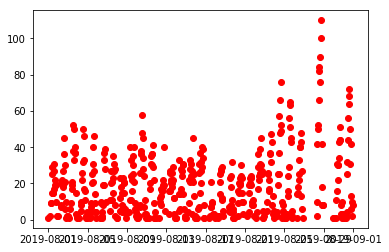

In [339]:
plt.plot(x, y, 'ro')

In [212]:
len(X)

2427

In [312]:
y.plot('ro')

ValueError: ro is not a valid plot kind

In [340]:
2*2

4

In [343]:
60*24*7*4*4*14*2

4515840

In [344]:
import random

In [349]:
random.sample(list(np.arange(0,14)),10)

[11, 4, 2, 12, 13, 5, 9, 1, 10, 3]

In [347]:
list(np.arange(0,14))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]